<a href="https://colab.research.google.com/github/Tlen33/Genetic-Algorithms-for-Training-Neural-Networks/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D
from keras.losses import MAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import keras.backend as K
import random as random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/My Drive/Базы/traff.csv',header=None)

In [ ]:
# Выводим пять первых строк
base_data.head()

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"


In [ ]:
# Берем только последний столбец
data = base_data.iloc[:,1]

In [ ]:
# Выводим параметры одного файла
d = data
print(len(d))         # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0])      # Пример первой строки данных

1095
9
22,226.00


In [ ]:
data = np.array(data) # Превращаем в numpy массив
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

In [ ]:
# Формируем параметры загрузки данных

xLen = 60     # Анализируем по 60 прошедшим точкам 
valLen = 300  # Используем 300 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки 
Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)


# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(Train, Train,             # в качестве параметров наши выборки
                               length=xLen, sampling_rate=1, # для каждой точки
                               batch_size=20)                # размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
# Функция для расчета результата прогнозирования сети

# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходный масштаб данных до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка, с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean()      # Среднее значение первого вектора
  mb = b.mean()      # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std()       # Среднеквадратичное отклонение первого вектора
  sb = b.std()       # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция отрисовки корреляции спрогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для расчёта корреляции
# showGraf - показываем график или нет
# returnData - возвращаем массивы автокорреляции или нет
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: # Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf:   # Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: # Если нужно вернуть массивы автокорреляции
    return corr, own_corr

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки

DataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=len(Test)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
# Создаём сеть (net - список параметров)

def createConvNet(net):  
  makeFirstNormalization = net[0] # Вероятность применения нормализации вначале
  maxPoolKernel = net[1]          # Ядро пулинга
  firstConvSize = 2 ** net[2]     # Размер первого cвёрточного слоя
  firstConvKernel = net[3]        # Ядро первого свёрточного слоя
  activation1 = net[4]            # Функция активации первого слоя

  secondConvProb = net[5]         # Вероятность добавления доп. сверточного слоя
  secondConvcount = net[6]        # Кол-во доп. сверточных слоев
  secondConvSizeMin = net[7]      # Мин. размер доп. свёрточного слоя
  secondConvSizeMax = net[8]      # Макс. размер доп. свёрточного слоя
  secondConvSizeMode = net[9]     # Выбирать размеры слоев случайно: 0 - случайно, 1 - последовательно, 2 - мин., 3 - макс.
  secondConvKernelMin = net[10]   # Мин. ядро доп. свёрточного слоя
  secondConvKernelMax = net[11]   # Макс. ядро доп. свёрточного слоя
  secondConvKernelMode = net[12]  # Выбирать ядро доп. свёрточного слоя: 0 - случайно, 1 - последовательно, 2 - мин., 3 - макс.
  makePool2 = net[13]             # Вероятность применения пуллинга?
  activation2 = net[14]           # Функция активации доп. слоя

  denseProb = net[15]             # Вероятность добаления полносвязного слоя
  denseCount = net[16]            # Кол-во полносвязных слоев
  denseSizeMin = net[17]          # Мин. размер полносвязного слоя
  denseSizeMax = net[18]          # Макс. размер полносвязного слоя
  denseSizeMode = net[19]         # Выбирать размер полносвязного слоя: 0 - случайно, 1 - последовательно, 2 - мин., 3 - макс.
  activation6 = net[20]           # Функция активации полносвязного слоя

  shape = (xLen, 1)               # Размер входных данных
  inputs = Input(shape)           # Входной слой

  # Список активационных функций
  activation_list = ['linear','relu','tanh','softmax','sigmoid']

  if (random.random() < makeFirstNormalization):    
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize, firstConvKernel, padding ='same')(x)
    x1 = Activation(activation_list[activation1])(x)
  else:                        
    x = Conv1D(firstConvSize, firstConvKernel, padding ='same')(inputs)
    x = Activation(activation_list[activation1])(x)

  if random.random() < makePool2:    # Добавление пулинга
    x = MaxPooling1D(maxPoolKernel)(x)

  for i in range(secondConvcount):   # Добавление блока  
    if random.random() < secondConvProb:
      size = 0
      kernel = 0

      if secondConvSizeMode == 0:
        size = int(np.random.uniform(secondConvSizeMin, secondConvSizeMax))
      elif secondConvSizeMode == 1:
        if (i < len(range(secondConvSizeMin, secondConvSizeMax))):
          size = range(secondConvSizeMin, secondConvSizeMax)[i]
        else:
          size = secondConvSizeMax
      elif secondConvSizeMode == 2:
        size = secondConvSizeMin
      elif secondConvSizeMode == 3:
        size = secondConvSizeMax

      if secondConvKernelMode == 0:
        kernel = int(np.random.uniform(secondConvKernelMin, secondConvKernelMax))
      elif secondConvKernelMode == 1:
        if (i < len(range(secondConvKernelMin, secondConvKernelMin))):
          kernel = range(secondConvKernelMin, secondConvKernelMin)[i]
        else:
          kernel = secondConvKernelMin
      elif secondConvKernelMode == 2:
        kernel = secondConvKernelMin
      elif secondConvKernelMode == 3:
        kernel = secondConvKernelMin

      x = Conv1D(2 ** size, kernel, padding ='same')(x)
      x = Activation(activation_list[activation2])(x)    

  x = Flatten()(x)

  # Добавление полносвязного слоя
  for i in range(denseCount):
    if random.random() < denseProb:
      size = 0

      if denseSizeMode == 0:
        size = int(np.random.uniform(denseSizeMin, denseSizeMax))
      elif denseSizeMode == 1:
        if (i < len(range(denseSizeMin, denseSizeMax))):
          size = range(denseSizeMin, denseSizeMax)[i]
        else:
          size = denseSizeMax
      elif denseSizeMode == 2:
        size = denseSizeMin
      elif denseSizeMode == 3:
        size = denseSizeMax

      x = Dense(2 ** size)(x)
      x = Activation(activation_list[activation6])(x)

  x = Dense(1)(x)

  model = Model(inputs, x) 
  return model

'''
  Функция вычисления результата работы сети
'''
def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net) # Создаем модель createConvNet

  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  history = model.fit_generator(trainDataGen,
                    epochs=5, 
                    verbose=verb,
                    validation_data=testDataGen)
    
  val = history.history["val_loss"][-1] # Возвращаем точность на проверочной выборке с последней эпохи
  
  return val, model                      # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1))   # Вероятность применения нормализации
  net.append(random.randint(2,4))   # Ядро maxPooling
  net.append(random.randint(2,10))  # Первый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,9))   # Ядро первого свёрточного слоя от 3 до 9
  net.append(random.randint(0,4))   # Функция активации  

  net.append(random.randint(0,1))   # Вероятность добавления доп. сверточного слоя
  net.append(random.randint(0,5))   # Кол-во доп. сверточных слоев
  net.append(2)                     # Мин. размер сверточного слоя
  net.append(6)                     # Макс. размер сверточного слоя
  net.append(random.randint(0,3))   # Как выбирать размер: случайно, последовательно, мин., макс.
  net.append(2)                     # Мин. размер ядра
  net.append(9)                     # Макс. размер ядра
  net.append(random.randint(0,3))   # Как выбирать ядро: случайно, последовательно, мин., макс.
  net.append(random.randint(0,1))   # Вероятность применения MaxPooling
  net.append(random.randint(0,4))   # Функция активации
  
  net.append(random.randint(0,1))   # Вероятность добавления полносвязного слоя
  net.append(random.randint(0,5))   # Кол-во полносвязных слоев
  net.append(2)                     # Мин. размер полносвязного слоя
  net.append(6)                     # Макс. размер полносвязного слоя
  net.append(random.randint(0,3))   # Как выбирать размер: случайно, последовательно, мин., макс.
  net.append(random.randint(0,4))   # Функция активации
  
  return net

In [ ]:
n = 20              # Общее число ботов
nsurv = 10          # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 21              # Размер бота
epohs = 10          # Количество эпох
mut = 0.09          # Коэффициент мутаций
popul = []          # Массив популяции
val = []            # Одномерный массив значений этих ботов

# Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):                 # Пробегаем по всем эпохам
  val = []                              # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):                    # Пробегаем в цикле по всем ботам 
    bot = popul[i]                      # Берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # Вычисляем точность текущего бота
    val.append(f)                       # Добавляем полученное значение в список val
  
  sval = sorted(val, reverse=0)         # Сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

0 27.60712218284607   [0.009554603137075901, 0.015358573757112026, 0.028226839378476143, 0.03338782861828804, 0.04825432226061821] [[0, 3, 5, 6, 3, 0, 5, 2, 6, 1, 2, 9, 2, 0, 3, 0, 4, 2, 6, 0, 3], [0, 2, 5, 6, 0, 0, 0, 2, 6, 2, 2, 9, 0, 1, 2, 1, 4, 2, 6, 2, 1], [1, 4, 5, 5, 1, 0, 1, 2, 6, 0, 2, 9, 2, 0, 4, 1, 0, 2, 6, 1, 4], [0, 3, 10, 8, 3, 0, 5, 2, 6, 3, 2, 9, 0, 0, 4, 0, 0, 2, 6, 1, 4], [0, 3, 10, 4, 3, 1, 0, 2, 6, 0, 2, 9, 0, 1, 1, 1, 3, 2, 6, 3, 1]]
1 24.404287815093994   [0.006811241153627634, 0.01709459163248539, 0.017156893387436867, 0.021801525726914406, 0.023901497945189476] [[0, 3, 5, 4, 0, 1, 0, 2, 6, 2, 2, 9, 0, 0, 1, 1, 1, 2, 6, 0, 0], [0, 3, 10, 5, 0, 0, 2, 2, 6, 0, 2, 9, 3, 1, 1, 1, 1, 2, 6, 3, 4], [0, 2, 7, 7, 1, 0, 0, 2, 6, 2, 2, 9, 3, 1, 4, 0, 2, 2, 6, 0, 0], [0, 4, 6, 6, 1, 1, 4, 2, 6, 3, 2, 9, 3, 1, 1, 1, 4, 2, 6, 0, 1], [1, 4, 7, 8, 2, 0, 3, 2, 6, 2, 2, 9, 0, 0, 3, 0, 4, 2, 6, 2, 2]]
2 22.520238399505615   [0.0046993643045425415, 0.007687719538807869, 0.0101273879

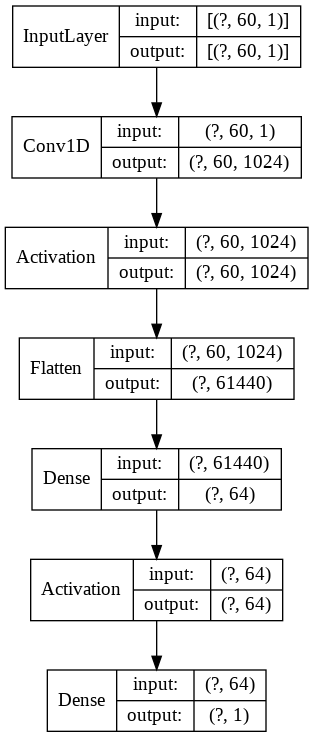

In [ ]:
model = createConvNet(popul[0])
#model.summary()
plot_model(model, show_layer_names=False, show_shapes=True)

Epoch 1/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 11/50
37/37 [

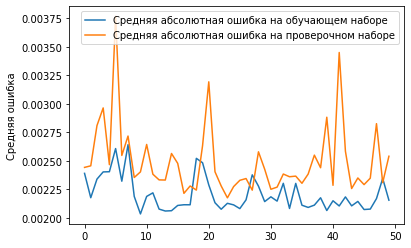

In [ ]:
# Компилируем и обучаем
model.compile(optimizer=Adam(lr=1e-5),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=50, 
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

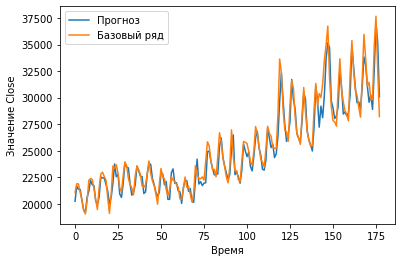

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model # Выбираем текущую модель

# Прогнозируем данные
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) 

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

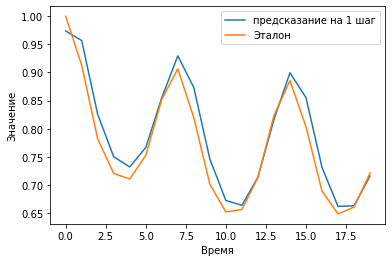

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 20, predVal, yValUnscaled)